In [1]:
# Preamble (system)
import sys
import os

if sys.version_info[0] < 3:
  raise AssertionError('Please run this notebook with Python 3.')

# Preamble (tools)
import numpy as np
import collections
import contextlib
import functools
import itertools
import more_itertools

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Preamble (ML)
np.random.seed(2027)  # set random seed

import tensorflow as tf
tf.random.set_seed(2027)  # set random seed

import dask
import dask.array as da

In [2]:
# Preamble (EMTF)
from emtf_nbtools import get_logger, get_colormap, emtf_nbtools

try:
  import emtf_nnet
except ImportError:
  raise ImportError('Could not import emtf_nnet. It can be found at '
                    'https://github.com/jiafulow/emtf-nnet')

# Get plot style and color map
plt.style.use('tdrstyle.mplstyle')
cm = get_colormap()

# Get logger
logger = get_logger()
logger.info('Using cmssw      : {}'.format(os.environ.get('CMSSW_VERSION', 'N/A')))
logger.info('Using python     : {}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {}'.format(np.__version__))
logger.info('Using matplotlib : {}'.format(matplotlib.__version__))
logger.info('Using tensorflow : {}'.format(tf.__version__))
logger.info('Using keras      : {}'.format(tf.keras.__version__))
logger.info('.. list devices  : {}'.format(tf.config.list_physical_devices()))
logger.info('Using dask       : {}'.format(dask.__version__))
logger.info('Using emtf-nnet  : {}'.format(emtf_nnet.__version__))

[INFO    ] Using cmssw      : N/A
[INFO    ] Using python     : 3.9.12 (main, Jun  1 2022, 11:38:51) [GCC 7.5.0]
[INFO    ] Using numpy      : 1.20.3
[INFO    ] Using matplotlib : 3.5.1
[INFO    ] Using tensorflow : 2.6.0
[INFO    ] Using keras      : 2.6.0
2022-06-28 01:15:15.184104: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
[INFO    ] .. list devices  : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
2022-06-28 01:15:15.184159: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
[INFO    ] Using dask       :

In [3]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
zone = 0
#zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(0,-1,-2)
timezone = 0

#maxevents = 100
maxevents = -1

#workers = 1
workers = 8

# Input files
signal_fname = 'signal.210922.npz'
signal_dxy_fname = 'signal_dxy.210922.npz'
bkgnd_fname = 'bkgnd.210922.npz'

# Model files
patterns_fname = 'patterns_dxy_zone%i.npz' % zone
nnet_model_fname = 'nnet_model.json'

logger.info('Using settings   : |')
logger.info('.. zone          : {}'.format(zone))
logger.info('.. timezone      : {}'.format(timezone))
logger.info('.. maxevents     : {}'.format(maxevents))
logger.info('.. workers       : {}'.format(workers))

[INFO    ] Using settings   : |
[INFO    ] .. zone          : 0
[INFO    ] .. timezone      : 0
[INFO    ] .. maxevents     : -1
[INFO    ] .. workers       : 8


### Load data

In [4]:
def load_signal(fname):
  logger.info('Loading from {}'.format(fname))
  with np.load(fname) as loaded:
    out_part = loaded['out_part']
    out_hits_values = loaded['out_hits_values']
    out_hits_row_splits = loaded['out_hits_row_splits']
    out_hits_shape = (out_hits_row_splits.shape[0] - 1,) + (None,) + out_hits_values.shape[1:]
    out_simhits_values = loaded['out_simhits_values']
    out_simhits_row_splits = loaded['out_simhits_row_splits']
    out_simhits_shape = (out_simhits_row_splits.shape[0] - 1,) + (None,) + out_simhits_values.shape[1:]
  logger.info('out_part: {}, out_hits: {}, out_simhits: {}'.format(
      (out_part.shape, out_part.dtype.name),
      (out_hits_shape, out_hits_values.dtype.name),
      (out_simhits_shape, out_simhits_values.dtype.name)))
  return (out_part, (out_hits_values, out_hits_row_splits), (out_simhits_values, out_simhits_row_splits))


def load_bkgnd(fname):
  logger.info('Loading from {}'.format(fname))
  with np.load(fname) as loaded:
    bkg_aux = loaded['out_aux']
    bkg_hits_values = loaded['out_hits_values']
    bkg_hits_row_splits = loaded['out_hits_row_splits']
    bkg_hits_shape = (bkg_hits_row_splits.shape[0] - 1,) + (None,) + bkg_hits_values.shape[1:]
  logger.info('bkg_aux: {} bkg_hits: {}'.format(
      (bkg_aux.shape, bkg_aux.dtype.name),
      (bkg_hits_shape, bkg_hits_values.dtype.name)))
  return (bkg_aux, (bkg_hits_values, bkg_hits_row_splits))

In [5]:
# Load data
out_part, out_hits, out_simhits = load_signal(signal_dxy_fname)

bkg_aux, bkg_hits = load_bkgnd(bkgnd_fname)

[INFO    ] Loading from signal_dxy.210922.npz
[INFO    ] out_part: ((3590546, 10), 'float32'), out_hits: ((3590546, None, 17), 'int32'), out_simhits: ((3590546, None, 17), 'int32')
[INFO    ] Loading from bkgnd.210922.npz
[INFO    ] bkg_aux: ((986400, 2), 'int32') bkg_hits: ((986400, None, 17), 'int32')


In [6]:
class PatternHelper(object):
  """Reshapes patterns for use in NN."""
  def get_reshaped_patterns(self, patterns):
    patterns = patterns[:, 3]  # displaced patterns only
    patterns = patterns[[3, 2, 4, 1, 5, 0, 6]]  # ordered by straightness
    return patterns  # shape is (7, 8, 3)

  def get_reshaped_patt_filters(self, patt_filters):
    patt_filters = patt_filters[:, 3]  # displaced patterns only
    patt_filters = patt_filters[[3, 2, 4, 1, 5, 0, 6]]  # ordered by straightness
    patt_filters = np.transpose(patt_filters, [3, 2, 1, 0])  # kernel shape is HWCD
    return patt_filters  # shape is (1, 111, 8, 7)

  def get_reshaped_patt_activations(self, patt_activations):
    patt_activations = patt_activations // 4  # from 8-bit to 6-bit
    po2_coeffs = (2 ** np.arange(8))  # [1,2,4,8,16,32,64,128]
    patt_activations[0] = 0           # set to zero if empty hit
    patt_activations[po2_coeffs] = 0  # set to zero if single hit
    assert patt_activations.max() == (64 - 1)
    return patt_activations  # shape is (256,)


def load_patterns():
  num_emtf_zones = 3
  helper = PatternHelper()

  patterns = []
  patt_filters = []
  patt_activations = []
  for z in range(num_emtf_zones):
    fname = patterns_fname.replace('zone%i' % zone, 'zone%i' % z)  # modify filename
    logger.info('Loading from {}'.format(fname))
    with np.load(fname) as loaded:
      patterns.append(helper.get_reshaped_patterns(loaded['patterns']))
      patt_filters.append(helper.get_reshaped_patt_filters(loaded['patt_filters']))
      patt_activations.append(helper.get_reshaped_patt_activations(loaded['patt_activations']))

  patterns = np.asarray(patterns)
  patt_filters = np.asarray(patt_filters)
  patt_activations = np.asarray(patt_activations)
  logger.info('patterns: {} patt_filters: {} patt_activations: {}'.format(
      patterns.shape, patt_filters.shape, patt_activations.shape))

  # Dump constants
  pattern_bank = emtf_nnet.keras.utils.PatternBank(patterns, patt_filters, patt_activations)
  emtf_nnet.keras.utils.save_pattern_bank(pattern_bank)  # write to file
  loaded_pattern_bank = emtf_nnet.keras.utils.load_pattern_bank('pattern_bank.json')
  return loaded_pattern_bank


def load_nnet_model():
  from emtf_nnet.keras.quantization import default_quantize_scheme
  path = nnet_model_fname
  w_path = path.replace('.json', '_weights.h5')
  custom_objects = default_quantize_scheme.DefaultQuantizeScheme._QUANTIZATION_OBJECTS
  logger.info('Loading from {}'.format(path))
  loaded_nnet_model = emtf_nnet.keras.utils.load_nnet_model(path, w_path, custom_objects)
  loaded_nnet_model.trainable = False
  logger.info('NN model: {}'.format(loaded_nnet_model.name))

  #FIXME: The following is needed to write the NN weights into a file. Currently disabled.
  if False:
    # Make sure all the tensors are computed
    input_shape = loaded_nnet_model.inputs[0].shape
    _ = loaded_nnet_model(np.random.random_sample((1,) + input_shape[1:]))
    # Dump weights
    weights = [
      #FIXME: hardcoded dequantizer
      loaded_nnet_model.get_layer('quant_preprocessing').layer.scale.numpy() * np.power(2., 10),
      np.zeros(loaded_nnet_model.inputs[0].shape[-1], dtype=np.float32),
      loaded_nnet_model.get_layer('quant_dense').layer.folded_kernel.numpy() * np.power(2., 6),
      loaded_nnet_model.get_layer('quant_dense').layer.folded_bias.numpy() * np.power(2., 6),
      loaded_nnet_model.get_layer('quant_dense_1').layer.folded_kernel.numpy() * np.power(2., 6),
      loaded_nnet_model.get_layer('quant_dense_1').layer.folded_bias.numpy() * np.power(2., 6),
      loaded_nnet_model.get_layer('quant_dense_2').layer.folded_kernel.numpy() * np.power(2., 6),
      loaded_nnet_model.get_layer('quant_dense_2').layer.folded_bias.numpy() * np.power(2., 6),
      loaded_nnet_model.get_layer('quant_dense_final').layer.folded_kernel.numpy().squeeze() * np.power(2., 9),
      np.zeros(loaded_nnet_model.outputs[0].shape[-1], dtype=np.float32),
    ]
    emtf_nnet.keras.utils.save_serializable_object(weights, 'nnet_weights.json')  # write to file
  return loaded_nnet_model

In [7]:
# Load pattern bank, NN model
loaded_pattern_bank = load_patterns()

loaded_nnet_model = load_nnet_model()

[INFO    ] Loading from patterns_dxy_zone0.npz
[INFO    ] Loading from patterns_dxy_zone1.npz
[INFO    ] Loading from patterns_dxy_zone2.npz
[INFO    ] patterns: (3, 7, 8, 3) patt_filters: (3, 1, 111, 8, 7) patt_activations: (3, 256)
[INFO    ] Loading from nnet_model.json
2022-06-28 01:15:25.831035: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[INFO    ] NN model: nnet_model


### Create inputs

In [8]:
# Configure
from emtf_nnet.architecture import endless_v3

tf.config.optimizer.set_jit(True)  # enable XLA
#tf.config.threading.set_inter_op_parallelism_threads(32)
#tf.config.threading.set_intra_op_parallelism_threads(32)

endless_v3.set_pattern_bank(loaded_pattern_bank)
endless_v3.set_nnet_model(loaded_nnet_model)
config = endless_v3.configure()
endless_v3.set_config(config)

In [9]:
# Create inputs
sector_part, sector_hits, sector_simhits = endless_v3.create_sector_hits(out_part, out_hits, out_simhits)
out_part, out_hits, out_simhits = None, None, None  # not needed anymore

logger.info('sector_part: {} sector_hits: {} sector_simhits: {}'.format(
    sector_part.shape, sector_hits.shape, sector_simhits.shape))

[INFO    ] sector_part: (2205856, 10) sector_hits: (2205856, None, 17) sector_simhits: (2205856, None, 17)


In [10]:
sector_noises_aux, sector_noises = endless_v3.create_sector_noises(bkg_aux, bkg_hits)
bkg_aux, bkg_hits = None, None  # not needed anymore

logger.info('sector_noises_aux: {} sector_noises: {}'.format(
    sector_noises_aux.shape, sector_noises.shape))

[INFO    ] sector_noises_aux: (353468, 2) sector_noises: (353468, None, 17)


In [11]:
batch_size = 1024

datagen_sparse = endless_v3.get_datagen_sparse(sector_hits, batch_size=batch_size)
try:
  x_test_sparse = datagen_sparse[0]
except:
  raise ValueError('Fail to get data from datagen_sparse.')

datagen = endless_v3.get_datagen(sector_hits, batch_size=batch_size)
try:
  x_test = datagen[0]
except:
  raise ValueError('Fail to get data from datagen.')

datagen_noise = endless_v3.get_datagen_shuffle(sector_noises, batch_size=batch_size)
try:
  x_test_noise = datagen_noise[0]
except:
  raise ValueError('Fail to get data from datagen_noise.')

assert isinstance(x_test_sparse, np.ndarray) and len(x_test_sparse) == batch_size
assert isinstance(x_test, np.ndarray) and len(x_test) == batch_size and x_test.ndim == 4
assert isinstance(x_test_noise, np.ndarray) and len(x_test_noise) == batch_size and x_test_noise.ndim == 4

In [12]:
# Debug
my_array2string = functools.partial(
    np.array2string, separator=', ', max_line_width=100, formatter={'int': (lambda x: '% 4d' % x)})

print(my_array2string(x_test_sparse[0]))
print(my_array2string(x_test_sparse[1]))
print(my_array2string(x_test_sparse[2]))

[[   6,    0,  1505,    4,   98,    0,    6,    8,    0,    0,    4,    0,    0,    0,    1],
 [  21,    0,  1628,    4,   97,    0,    6,    8,    0,    0,    4,    0,    0,    0,    1],
 [  30,    0,  1704,    4,   97,    0,    6,    8,    0,    0,    4,    1,    0,    0,    1]]
[[   2,    0,  2976,   -8,    4,    0,    6,    7,    0,    4,    4,    0,    0,    0,    1],
 [  18,    0,  2487,    0,   12,    0,    6,   10,    0,    4,    4,    0,    0,    0,    1],
 [  19,    0,  2520,    0,   11,    0,    6,   10,    0,    4,    4,    1,    0,    0,    1],
 [  27,    0,  2392,   -4,   13,    0,    6,    9,    0,    4,    4,    1,    0,    0,    1],
 [  36,    0,  2336,    0,   15,    0,    6,   10,    0,    4,    4,    1,    0,    0,    1],
 [  73,    0,  2553,    0,   13,    0,    0,    0,    0,    4,    4,    1,    1,    0,    1],
 [  81,    0,  2364,    0,   15,    0,    0,    0,    0,    4,    4,    1,    1,    0,    1],
 [  90,    0,  2309,    0,   16,    0,    0,    0,    0,    

In [13]:
# Debug
isvalid = lambda x: (x[..., -1] != 0)  # x[..., -1] is the valid flag

print(x_test.shape)
print(my_array2string(x_test[0][isvalid(x_test[0])]))
print(my_array2string(x_test[1][isvalid(x_test[1])]))
print(my_array2string(x_test[2][isvalid(x_test[2])]))

(1024, 115, 2, 13)
[[ 1505,    4,   98,    0,    6,    8,    0,    0,    4,    0,    0,    0,    1],
 [ 1628,    4,   97,    0,    6,    8,    0,    0,    4,    0,    0,    0,    1],
 [ 1704,    4,   97,    0,    6,    8,    0,    0,    4,    1,    0,    0,    1]]
[[ 2976,   -8,    4,    0,    6,    7,    0,    4,    4,    0,    0,    0,    1],
 [ 2487,    0,   12,    0,    6,   10,    0,    4,    4,    0,    0,    0,    1],
 [ 2520,    0,   11,    0,    6,   10,    0,    4,    4,    1,    0,    0,    1],
 [ 2392,   -4,   13,    0,    6,    9,    0,    4,    4,    1,    0,    0,    1],
 [ 2336,    0,   15,    0,    6,   10,    0,    4,    4,    1,    0,    0,    1],
 [ 2553,    0,   13,    0,    0,    0,    0,    4,    4,    1,    1,    0,    1],
 [ 2364,    0,   15,    0,    0,    0,    0,    4,    4,    1,    1,    0,    1],
 [ 2309,    0,   16,    0,    0,    0,    0,    4,    4,    1,    1,    0,    1]]
[[ 4695,  -16,   20,    0,    6,    3,    0,    4,    4,    1,    0,    0,    1

### Create model

In [14]:
# Create model
model = endless_v3.create_model()
model.summary()

Model: "endless_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 115, 2, 13)] 0                                            
__________________________________________________________________________________________________
zoning_0 (Zoning)               (None, 8, 288, 1)    0           inputs[0][0]                     
__________________________________________________________________________________________________
zoning_1 (Zoning)               (None, 8, 288, 1)    0           inputs[0][0]                     
__________________________________________________________________________________________________
zoning_2 (Zoning)               (None, 8, 288, 1)    0           inputs[0][0]                     
_________________________________________________________________________________________

In [15]:
# Make predictions
num_test_samples = x_test.shape[0] if maxevents == -1 else maxevents
x_test_1 = x_test[:num_test_samples]
x_test_sparse_1 = x_test_sparse[:num_test_samples]

outputs = model.predict(x_test_1, workers=workers, use_multiprocessing=False)  # now wait...
if isinstance(outputs, tuple):
  for i in range(len(outputs)):
    logger.info('outputs: {}'.format((outputs[i].shape, outputs[i].dtype.name)))
else:
  logger.info('outputs: {}'.format((outputs.shape, outputs.dtype.name)))

2022-06-28 01:15:52.288827: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2022-06-28 01:16:00.945518: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x7f30ec040a70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-28 01:16:00.945593: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2022-06-28 01:16:01.245676: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2022-06-28 01:16:01.487390: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
[INFO    ] outputs: ((1024, 4, 40), 'int32')
[INFO    ] outputs: ((1024, 4, 12), 'int32')
[INFO    ] outputs: ((1024, 4, 1), 'bool')
[INFO    ] outputs: ((1024, 4, 1), 'float32')


In [16]:
# Debug
# outputs should be a tuple of size 4: trk_feat, trk_seg, passed, y_pred
outputs_0, outputs_1, outputs_2, outputs_3 = outputs
print(outputs_0, outputs_1, np.squeeze(outputs_2), np.squeeze(outputs_3))

[[[999999 999999 999999 ... 999999      0      0]
  [999999 999999 999999 ... 999999      0      0]
  [999999 999999 999999 ... 999999      0      0]
  [999999 999999 999999 ... 999999      0      0]]

 [[999999 999999     15 ...     13     63      0]
  [999999 999999 999999 ... 999999 999999 999999]
  [999999 999999 999999 ... 999999 999999 999999]
  [999999 999999 999999 ... 999999 999999 999999]]

 [[999999 999999      8 ...      8     63      0]
  [999999 999999 999999 ... 999999 999999 999999]
  [999999 999999 999999 ... 999999 999999 999999]
  [999999 999999 999999 ... 999999 999999 999999]]

 ...

 [[    19 999999 999999 ...     35     36      0]
  [999999 999999 999999 ... 999999      0      0]
  [999999 999999 999999 ... 999999 999999 999999]
  [999999 999999 999999 ... 999999 999999 999999]]

 [[999999     40      8 ...     63     63      0]
  [999999 999999 999999 ... 999999 999999 999999]
  [999999 999999 999999 ... 999999 999999 999999]
  [999999 999999 999999 ... 999999 9

In [17]:
# Debug
print(outputs_0[0, 0, :])
print(outputs_1[0, 0, :])
print(outputs_0[1, 0, :])
print(outputs_1[1, 0, :])
print(outputs_0[2, 0, :])
print(outputs_1[2, 0, :])
print(outputs_0[3, 0, :])
print(outputs_1[3, 0, :])

[999999 999999 999999 999999 999999 999999 999999 999999 999999 999999
 999999 999999 999999 999999 999999 999999 999999 999999 999999 999999
 999999 999999 999999 999999 999999 999999 999999 999999 999999 999999
 999999 999999 999999 999999 999999 999999 999999 999999      0      0]
[230 230 230 230 230 230 230 230 230 230 230 230]
[999999 999999     15    -80   -136 999999 999999   -108 999999 999999
 999999 999999 999999 999999     -1      0      2 999999 999999      2
 999999 999999 999999 999999 999999 999999      0     -4      0 999999
 999999 999999      6      6      6 999999   -272     13     63      0]
[230 230  36  54  72 230 230 162 230 230 230 230]
[999999 999999      8   -136   -224 999999 999999   -142   -260 999999
    110 999999 999999 999999      4      0     -1 999999 999999      1
     -1 999999      5 999999 999999 999999     -4      0     -4 999999
 999999 999999      6      6      6 999999    992      8     63      0]
[230 230  40  56  74 230 230 164 182 230 148 

In [18]:
extractor_layers = [
  model.get_layer('zonemerging_0').output,
  model.get_layer('trkbuilding_0').output,
  model.get_layer('duperemoval_0').output,
  model.get_layer('trainfilter_0').output,
  model.get_layer('fullyconnect_0').output,
]

extractor = tf.keras.Model(inputs=model.inputs, outputs=extractor_layers)

extracted = extractor.predict(x_test_1, workers=workers, use_multiprocessing=False)  # now wait...
extracted = iter(extracted)
extracted_zonemerging_0 = next(extracted)
extracted_trkbuilding_0 = next(extracted)
extracted_duperemoval_0 = next(extracted)
extracted_trainfilter_0 = next(extracted)[1:]   # drop features array from tuple
extracted_fullyconnect_0 = next(extracted)[1:]  # drop features array from tuple
assert isinstance(extracted_fullyconnect_0, tuple) and (len(extracted_fullyconnect_0) == 1)

#FIXME: hardcoded dequantizer
extracted_fullyconnect_0 = (extracted_fullyconnect_0[0] * np.power(2., 13),)

In [19]:
# Make testbench
if maxevents != -1:
  print(len(x_test_sparse_1))
  print(len(extracted_zonemerging_0), [x.shape for x in extracted_zonemerging_0])
  print(len(extracted_trkbuilding_0), [x.shape for x in extracted_trkbuilding_0])
  print(len(extracted_duperemoval_0), [x.shape for x in extracted_duperemoval_0])
  print(len(extracted_trainfilter_0), [x.shape for x in extracted_trainfilter_0])
  print(len(extracted_fullyconnect_0), [x.shape for x in extracted_fullyconnect_0])

  save_serializable_object = emtf_nnet.keras.utils.save_serializable_object
  save_serializable_object(x_test_sparse_1, 'x_test_sparse.json')
  save_serializable_object(extracted_zonemerging_0, 'extracted_zonemerging_0.json')
  save_serializable_object(extracted_trkbuilding_0, 'extracted_trkbuilding_0.json')
  save_serializable_object(extracted_duperemoval_0, 'extracted_duperemoval_0.json')
  save_serializable_object(extracted_trainfilter_0, 'extracted_trainfilter_0.json')
  save_serializable_object(extracted_fullyconnect_0, 'extracted_fullyconnect_0.json')

### Evaluate model

In [20]:
%%time

if maxevents == -1:
  outputs = model.predict(datagen, workers=workers, use_multiprocessing=False)  # now wait...
  if isinstance(outputs, tuple):
    for i in range(len(outputs)):
      logger.info('outputs: {}'.format((outputs[i].shape, outputs[i].dtype.name)))
  else:
    logger.info('outputs: {}'.format((outputs.shape, outputs.dtype.name)))

2022-06-28 02:04:23.781011: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1411747840 exceeds 10% of free system memory.
[INFO    ] outputs: ((2205856, 4, 40), 'int32')
[INFO    ] outputs: ((2205856, 4, 12), 'int32')
[INFO    ] outputs: ((2205856, 4, 1), 'bool')
[INFO    ] outputs: ((2205856, 4, 1), 'float32')


CPU times: user 2h 28min 23s, sys: 16min 13s, total: 2h 44min 36s
Wall time: 48min 8s


In [21]:
# Collect features and truths for training
if maxevents == -1:
  features = outputs[0][:, 0, :]  # first track only
  truths = sector_part

  passed = outputs[2][:, 0, 0]  # first track only, squeeze last dim
  features, truths = (x[passed] for x in (features, truths))  # 'passed' only
  logger.info('features: {}'.format((features.shape, features.dtype.name)))
  logger.info('truths: {}'.format((truths.shape, truths.dtype.name)))

[INFO    ] features: ((801909, 40), 'int32')
[INFO    ] truths: ((801909, 10), 'float32')


In [22]:
def ma_fill_value():
  return 999999


def latticeplot():
  ni, nj = (xdata.shape[1] + 5) // 6, 6
  fig, axs = plt.subplots(ni, nj, figsize=(6, 6 * ni / nj))

  for i in range(ni):
    for j in range(nj):
      ij = (i * nj) + j
      if ij >= xdata.shape[1]:
        break

      if axs.ndim == 2:
        ax = axs[i, j]
      elif axs.ndim == 1:
        ax = axs[j]
      else:
        ax = axs
      ax.hist(xdata[:, ij][xmask[:, ij]], bins=32)
      ax.set_xticklabels([])
      ax.set_yticklabels([])

  plt.show()

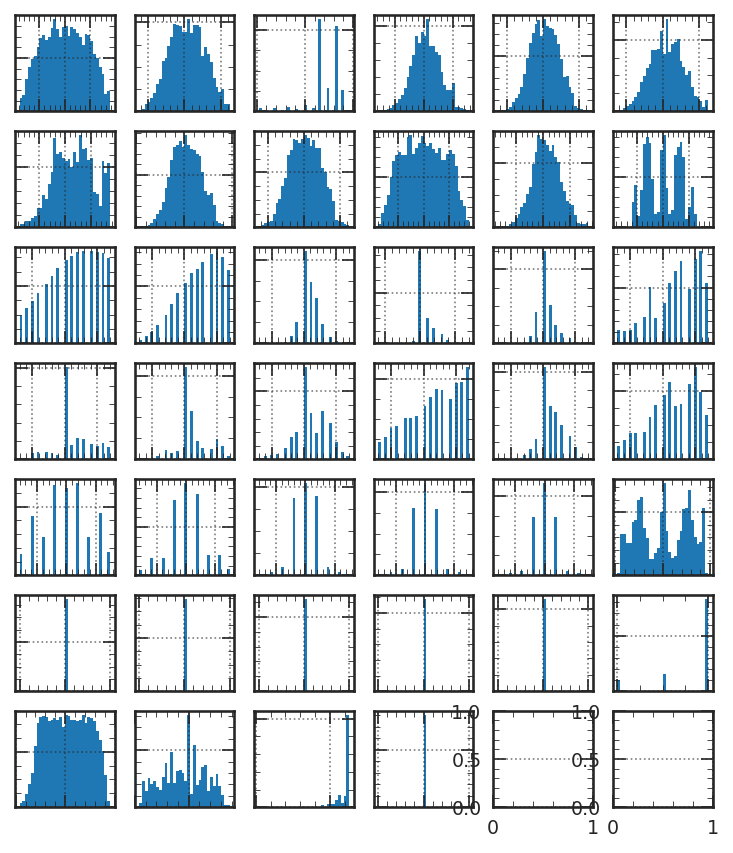

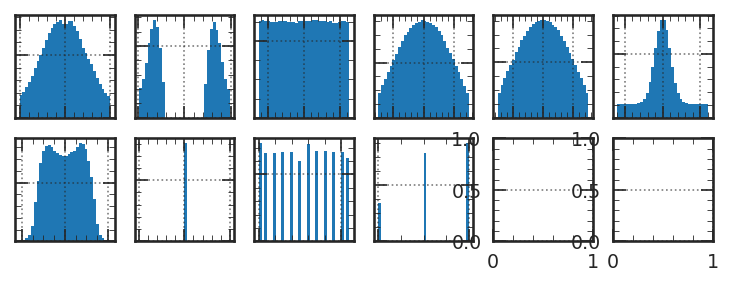

In [23]:
# Plot features and truths
if maxevents == -1:
  xdata = features
  xmask = (features != ma_fill_value())
  latticeplot()

  xdata = truths
  xmask = np.isfinite(truths)
  latticeplot()

### Make noise

In [24]:
%%time

if maxevents == -1:
  outputs = model.predict(datagen_noise, workers=workers, use_multiprocessing=False, steps=2000)  # now wait...
  if isinstance(outputs, tuple):
    for i in range(len(outputs)):
      logger.info('outputs: {}'.format((outputs[i].shape, outputs[i].dtype.name)))
  else:
    logger.info('outputs: {}'.format((outputs.shape, outputs.dtype.name)))

2022-06-28 02:49:33.766992: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1308044800 exceeds 10% of free system memory.
[INFO    ] outputs: ((2043820, 4, 40), 'int32')
[INFO    ] outputs: ((2043820, 4, 12), 'int32')
[INFO    ] outputs: ((2043820, 4, 1), 'bool')
[INFO    ] outputs: ((2043820, 4, 1), 'float32')


CPU times: user 2h 17min 56s, sys: 15min 26s, total: 2h 33min 23s
Wall time: 44min 58s


In [25]:
# Collect noises for training
if maxevents == -1:
  num_emtf_sites = 12
  # -3 is th_median index
  # -2 is trk_qual index
  # 12:24 are emtf_theta indices
  passed_0 = (outputs[0][:, :, -3] != 0)
  passed_1 = (outputs[0][:, :, -2] != 0)
  passed_2 = (outputs[0][:, :, (num_emtf_sites * 1):(num_emtf_sites * 2)] != ma_fill_value()).any(axis=-1)
  passed = passed_0 & passed_1 & passed_2
  noises = outputs[0][passed]  # 'passed' only

  # Shuffle
  shuffle = True
  if shuffle:
    index_array = np.arange(noises.shape[0])
    np.random.shuffle(index_array)
    noises = noises[index_array]
  logger.info('noises: {}'.format((noises.shape, noises.dtype.name)))

[INFO    ] noises: ((1548049, 40), 'int32')


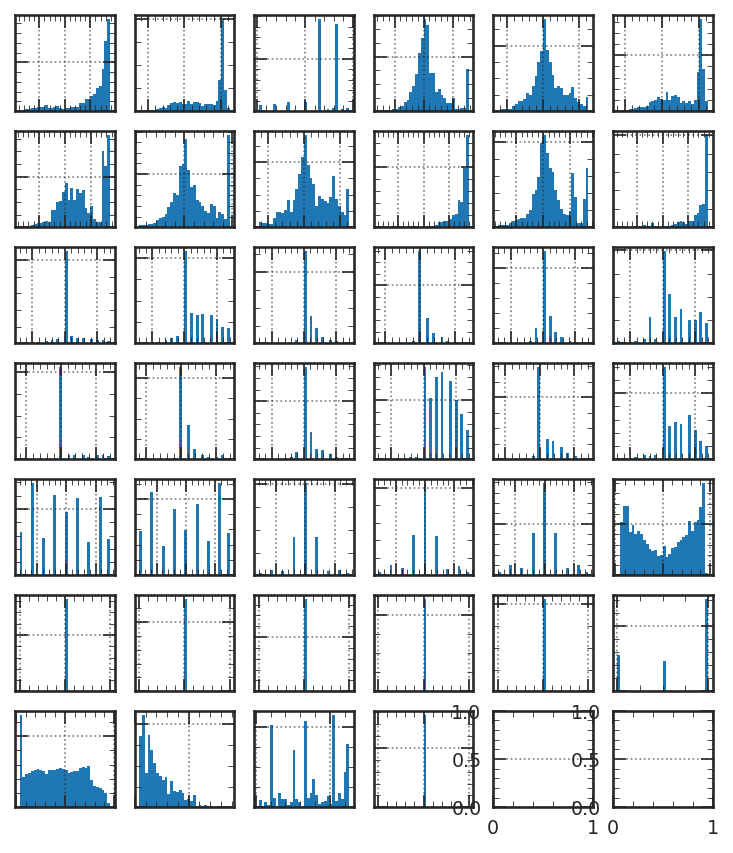

In [26]:
# Plot noises
if maxevents == -1:
  xdata = noises
  xmask = (noises != ma_fill_value())
  latticeplot()

In [27]:
# Write to file
if maxevents == -1:
  outfile = 'features_dxy.h5'
  outdict = {
    'features': da.from_array(features),
    'truths': da.from_array(truths),
    'noises': da.from_array(noises),
  }
  da.to_hdf5(outfile, outdict, compression='lzf')
  logger.info('Wrote to {}'.format(outfile))

[INFO    ] Wrote to features_dxy.h5
